In [42]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 887.6 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [45]:
import numpy as np
import pandas as pd
import votekit.elections as elec
from votekit import PreferenceInterval
import votekit.ballot_generator as bg
from glob import glob
import jsonlines as jl
from tqdm import tqdm
import json

In [ ]:
## Read in all dataframes
elec_df = pd.read_parquet("../JeffersonData/Jefferson_elections.parquet")
pop_df = pd.read_parquet("../JeffersonData/Jefferson_pop.parquet")
precincts_df =pd.read_parquet("../JeffersonData/Jefferson_precincts.parquet")
vap_df = pd.read_parquet("../JeffersonData/Jefferson_vap.parquet")


#### Extract SVT parameters from given datasets

In [9]:
print(pop_df.columns)
tot_pop = sum(pop_df.tot_pop_20)
h_pop = sum(pop_df.hpop_20)
print("percentage hispanic VAP: ", h_pop/tot_pop)
print(elec_df.columns)
tot_votes = sum(elec_df.pres_20_dem) + sum(elec_df.pres_20_rep)
dem_votes = sum(elec_df.pres_20_dem)
print(dem_votes / tot_votes)

Index(['tot_pop_20', 'bpop_20', 'hpop_20', 'asian_nhpi_pop_20', 'amin_pop_20',
       'other_pop_20', 'white_pop_20'],
      dtype='object')
percentage hispanic VAP:  0.15319002933557496
Index(['pres_08_dem', 'pres_08_rep', 'pres_12_dem', 'pres_12_rep',
       'pres_16_dem', 'pres_16_rep', 'sen_16_dem', 'sen_16_rep', 'gov_18_dem',
       'gov_18_rep', 'ag_18_dem', 'ag_18_rep', 'pres_20_dem', 'pres_20_rep',
       'sen_20_dem', 'sen_20_rep'],
      dtype='object')
0.5953878406708596


In [31]:
## Generate a profile

from votekit.pref_profile import profile_df_head


slate_to_candidates = {"Hisp": ["D1, D2, D3, D4, D5"], "Non-Hisp": ["R1, R2, R3, R4, R5"]}

# note that we include candidates with 0 support,
# and that our preference intervals will automatically rescale to sum to 1

pref_intervals_by_bloc = {
    "Hisp": {
        "Hisp": PreferenceInterval({"D1": 1, "D2":1, "D3": 1, "D4": 1, "D5": 1}),
        "Non-Hisp": PreferenceInterval({"R1": 1, "R2": 1, "R3": 1, "R4": 1, "R5": 1}),
    },
    "Non-Hisp": {
        "Hisp": PreferenceInterval({"D1": 1, "D2":1, "D3": 1, "D4": 1, "D5": 1}),
        "Non-Hisp": PreferenceInterval({"R1": 1, "R2": 1, "R3": 1, "R4": 1, "R5": 1}),
    },
}


bloc_voter_prop = {"Hisp": 0.15, "Non-Hisp": 0.85}

# assume that each bloc is 90% cohesive
# we'll discuss exactly what that means later
cohesion_parameters = {
    "Hisp": {"Hisp": 0.8, "Non-Hisp": 0.2},
    "Non-Hisp": {"Hisp": 0.5, "Non-Hisp": 0.5},
    # measured cohesion is about 60% demo 40% repub
}

pl = bg.slate_PlackettLuce(
    pref_intervals_by_bloc=pref_intervals_by_bloc,
    bloc_voter_prop=bloc_voter_prop,
    slate_to_candidates=slate_to_candidates,
    cohesion_parameters=cohesion_parameters,
)

# the by_bloc parameter allows us to see which ballots came from which blocs of voters
#profile_dict, agg_profile = pl.generate_profile(number_of_ballots=10000, by_bloc=True)
profile_dict = pl.generate_profile(number_of_ballots=10000)
'''
print("The ballots from Alpha voters\n", profile_df_head(profile_dict["Alpha"], 10))

print("The ballots from Xenon voters\n", profile_df_head(profile_dict["Xenon"],10))

print("Aggregated ballots\n", profile_df_head(agg_profile,10))
'''

## Run some elections with this profile
election = elec.STV(profile_dict, m=5)


In [ ]:
election
#tot_pop

'''
    So, what do we want to ask. Do we want to keep pushing up the
    percentage of the hispanic population? And then what do we want to
    measure? Do we want to just look at the bubble plots for different
    values of p_hisp?
    Or do we want to run gerrychain and look at the number democ seats
    won for different values of p_hisp?

    That would involve looking at the gerrychain code, so how about we
    look just at the bubble plots to begin and then we can look at the
    gerrychain code if we are not satisfied?


'''

        Status  Round
D3     Elected      5
D2     Elected      5
D4     Elected      5
D5     Elected      5
D1     Elected      5
R5   Remaining      5
R4  Eliminated      4
R1  Eliminated      3
R2  Eliminated      2
R3  Eliminated      1

In [33]:
dict(asfd=321423)

{'asfd': 321423}

In [ ]:
settings_files = glob("./jefferson_run_settings/*.json")
#settings_files = settings_files[:10]
print(settings_files)
with jl.open('partisan_election_hisp_results_5.jsonl','w') as writer:
    for setting_file in settings_files: #tqdm(settings_files):
        with open(setting_file, "r") as f:
            ballot_generator_kwargs = json.load(f)
            if ballot_generator_kwargs is None:
                ballot_generator_kwargs = {}
            #print(ballot_generator_kwargs)
            #break
        
        for trials in tqdm(range(100)):
            profile = bg.slate_PlackettLuce.from_params(**ballot_generator_kwargs).generate_profile(number_of_ballots=10000)

            election = elec.STV(profile, m=5)
            writer.write({
                "winners": [winner for winner_set in election.get_elected() for winner in winner_set],
                "hisp_perc": ballot_generator_kwargs["bloc_voter_prop"]["hisp"],
                #"cohesion": ballot_generator_kwargs["cohesion_parameters"]["D"]["D"],
                "m":5
                })

with jl.open('partisan_election_hisp_results_3.jsonl','w') as writer:
    for setting_file in settings_files: #tqdm(settings_files):
        with open(setting_file, "r") as f:
            ballot_generator_kwargs = json.load(f)
            if ballot_generator_kwargs is None:
                ballot_generator_kwargs = {}
            #print(ballot_generator_kwargs)
            #break
        
        for trials in tqdm(range(100)):
            profile = bg.slate_PlackettLuce.from_params(**ballot_generator_kwargs).generate_profile(number_of_ballots=10000)

            election = elec.STV(profile, m=3)
            writer.write({
                "winners": [winner for winner_set in election.get_elected() for winner in winner_set],
                "hisp_perc": ballot_generator_kwargs["bloc_voter_prop"]["hisp"],
                #"cohesion": ballot_generator_kwargs["cohesion_parameters"]["D"]["D"],
                "m":3
                })
        

['./jefferson_run_settings/hisp_prop_0p267_hisp_coh_0p8_non_hisp_coh_0p5.json', './jefferson_run_settings/hisp_prop_0p15_hisp_coh_0p8_non_hisp_coh_0p5.json', './jefferson_run_settings/hisp_prop_0p208_hisp_coh_0p8_non_hisp_coh_0p5.json', './jefferson_run_settings/hisp_prop_0p325_hisp_coh_0p8_non_hisp_coh_0p5.json', './jefferson_run_settings/hisp_prop_0p383_hisp_coh_0p8_non_hisp_coh_0p5.json', './jefferson_run_settings/hisp_prop_0p442_hisp_coh_0p8_non_hisp_coh_0p5.json', './jefferson_run_settings/hisp_prop_0p5_hisp_coh_0p8_non_hisp_coh_0p5.json']


  0%|          | 0/100 [00:00<?, ?it/s]

[0, 1, 9, 0, 0, 0]
[0, 3, 7, 0, 0, 0]
[0, 5, 5, 0, 0, 0]
[0, 6, 4, 0, 0, 0]
[0, 6, 4, 0, 0, 0]
[0, 8, 2, 0, 0, 0]
[0, 10, 0, 0, 0, 0]


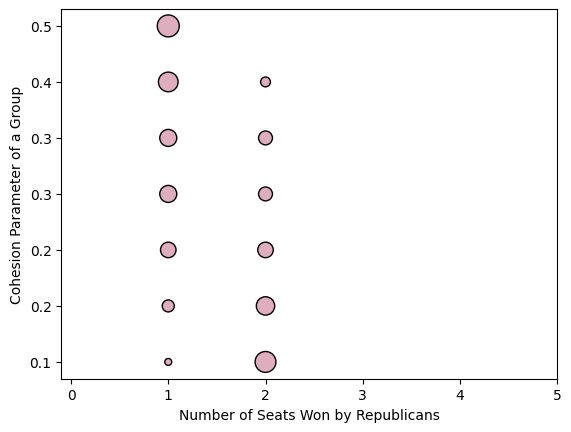

[0, 10, 0, 0, 0, 0]


In [ ]:
import pandas as pd
from typing import Optional
import numpy as np
from matplotlib.axes import Axes
import matplotlib.pyplot as plt

jsonl_file = "./partisan_election_hisp_results_5.jsonl"

def get_cohesions():
    election_df = pd.read_json(jsonl_file,lines = True)
    return election_df['cohesion'].tolist()

def get_percents():
    election_df = pd.read_json(jsonl_file,lines = True)
    return election_df['hisp_perc'].tolist()

def filter_df(election_df, m, hisp_perc):
    return election_df[(election_df.m == m) & (abs(election_df.hisp_perc - hisp_perc) <.001)]


def get_all_simulations():
    return pd.read_json(jsonl_file,lines = True)


def get_num_reps(winner_list):
    return len(list(filter(lambda x: 'R' in x, winner_list)))

def get_num_rep_win(election_df):
    winners_list = election_df['winners'].tolist()
    num_winners = [0,0,0,0,0,0] #0th element is 0 rep wins, 1st ele is 1 rep win, etc

    each_winner = []
    for trial in winners_list:
        num_reps = get_num_reps(trial)
        num_winners[num_reps] +=1
        each_winner.append(num_reps)
    return num_winners,each_winner



def bubble_plot_integer(
    data: list[list[int]],
    colors: list[str],
    ax: Optional[Axes] = None,
    marker: str =".",
    size: int = 1000,
):
    # create figure

    if ax is None:
        fig, ax = plt.subplots()

    x_max = int(max(max(vector) for vector in data))
    bin_min = 0
    bin_max = x_max
    bins = np.arange(bin_min-.5, bin_max+1.5, 1)

    for j, vector in enumerate(data):
        x = [i for i in range(x_max+1)] # x=0,...,x_max
        y = [j+1]*len(x) # put each vector at a different height

        bin_heights, _ = np.histogram(vector, bins = bins,density=True)
        circle_areas = [size*bin_heights[i] for i in range(x_max+1)]
        ax.scatter(x, y, s=circle_areas, alpha=1, color = colors[j], label = None, edgecolors='black', marker=marker)

    return ax


#cohesions = sorted(list(set(get_cohesions())))
percents = sorted(list(set(get_percents())))
election_df = get_all_simulations()
#cohesion = .9

each_winners = []
#percent = percents[9]
cohesion = 1
for hisp_perc in sorted(election_df["hisp_perc"].unique()):
    filtered_df = filter_df(election_df, 5, hisp_perc)
    rep_wins,each_winner = get_num_rep_win(filtered_df)
    print(rep_wins)
    each_winners.append(each_winner)



ax = bubble_plot_integer(data = each_winners, colors = ['#deadbeef' for x in range(len(each_winners))])
ax.set_yticks(ticks = [i+1 for i in range(len(percents))],labels= [float(int(i*10))/10 for i in percents])
ax.set_xticks([i for i in range(6)])
ax.set_ylabel("Percentage of Hispanics")
ax.set_xlabel("Number of Seats Won by Republicans")
plt.savefig("STV_Five_hisp_Winners.png")
plt.show()
print(rep_wins)
